In [1]:
import pandas as pd
import sys
sys.path.append("..")
from src.Utils import read_jsonlines
from src.Eval import get_iobs_from_data
import os

data = pd.read_parquet("../data/dataset/reddit+shsyt/data.parquet")#.drop_duplicates(subset="id")
data["yt_id"] = data.id.apply(lambda x: x.split("_", 1)[1])


data["has_WoA"] = data.IOB.apply(lambda x: "B-WoA" in x)
data["has_Artist"] = data.IOB.apply(lambda x: "B-Artist" in x)
data["index"] = data.groupby("subset").cumcount()


In [2]:

data_shs = pd.read_json("../data/raw/shs100k_metadata.jsonl", lines=True, orient="records")
data_shs = data_shs[['work_id', 'perf_id','perf_title', 'perf_artist']]
data_shs.columns = pd.MultiIndex.from_product([[''], data_shs.columns])

In [3]:
from typing import List
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import simplify_string, remove_bracket_with_one_content


def get_title_variations(s: str) -> List[str]:
    s = remove_bracket_with_one_content(s)
    l = s.split("/")
    l = [simplify_string(s) for s in l]
    return l

performer_processor = PerformerStringPreprocessor()

def get_performer_variations(s: str) -> List[str]:
    l = performer_processor.split_performers(s)
    l = [simplify_string(s) for s in l]
    l = performer_processor.article_preprocessing(l)
    return l

get_performer_variations("quentin tarantino feat. steven spielberg")


['quentin tarantino', 'steven spielberg']

# Factual Memorization

In [4]:
import pandas as pd
import ast

_ = pd.read_json("../data/intermediate/shs100k2_memorization.jsonl", lines=True, orient="records")

cols = []
for c in _.columns:
    new_c = ast.literal_eval(c)
    if new_c[1] == '':
        new_c = (new_c[1], new_c[0])
    cols.append(new_c)

_.columns = pd.MultiIndex.from_tuples(cols, names=["Model", ""])
_ = pd.merge(_, data_shs, 
                             how="left", on=[("", "work_id"), ("", "perf_id")])
# _ = _[[c for c in _.columns if "AW2" not in c[1]]]
_.columns = [(c[0], c[1].replace("AW3:", "AW2:")) for c in _.columns]
_ = _
_.columns = pd.MultiIndex.from_tuples(_.columns, names=["Model", ""])


In [5]:
models = []

for c in _.columns:
    model = c[0]
    if model != '' and model not in models:
        models.append(model)

        __ = _[model]

        _aw_cols = [c for c in __.columns if c.startswith("AW")]
        _aw_cols_related = [c for c in _aw_cols if "Related" in c]
        _aw_cols_correct = [c for c in _aw_cols if "Correct" in c]

        def correctness(row):
            if row[_aw_cols].T.sum() == 0:
                return "None"
            elif row[_aw_cols_correct].T.sum() >= 2:
                return "Correct"
            else:
                return "Partial"
            
        _[(model, "Correctness")] = __.apply(correctness, axis=1)
        _[(model, "Correctness")].value_counts()

__ = _[[("", "set_id")] + [(model, "Correctness") for model in models]]
__.columns = ["set_id"] + [f"{model}_Correctness" for model in models]
data_memorization = pd.merge(data, __, on="set_id", how="left")
data_memorization



,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,index,FireFunction-v2_Correctness,Llama3.1-70B_Correctness,Llama3.1-8B_Correctness,Mixtral-8x22B_Correctness
0,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,0,Correct,Correct,Correct,Correct
1,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,0,Partial,Partial,Partial,Partial
2,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,1,Correct,Correct,Correct,Correct
3,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,1,Partial,Partial,Partial,Partial
4,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,hQz-aZH-ozU,True,True,0,Partial,Partial,Partial,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5,746,True,True,657,NaN,NaN,NaN,NaN
3439,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1,747,True,True,659,NaN,NaN,NaN,NaN
3440,dataset4_748,12671.0,Reddit,"[soft, -, voiced, vocals]","[O, O, O, O]",2,748,False,False,659,NaN,NaN,NaN,NaN
3441,dataset4_749,12672.0,Reddit,"[find, me, music, with, dark, lyrics, covered,...","[O, O, O, O, O, O, O, O, O, O, O, O, O]",3,749,False,False,657,NaN,NaN,NaN,NaN


# Exposure

In [6]:
_ = pd.read_json("../data/intermediate/shs100k2_exposure.jsonl", lines=True, orient="records")

__ = pd.read_parquet("../data/raw/shs100k2_yt.parquet")[["set_id", "yt_id", "title", "performer"]]
__.title = __.title.str.lower()
__.performer = __.performer.str.lower()

_map = __.set_index(["set_id", "yt_id"]).to_dict()
data["title"] = data.apply(lambda x: _map["title"].get((x.set_id, x.yt_id)), axis=1)
data["performer"] = data.apply(lambda x: _map["performer"].get((x.set_id, x.yt_id)), axis=1)


_ = pd.concat(
    [pd.merge(
        data, 
        _.loc[_.Entity == "WoA"], 
        left_on=["set_id", "title"], 
        right_on=["set_id", "name"],
        how="left"),
     pd.merge(
         data, 
         _.loc[_.Entity == "Artist"], 
         left_on=["set_id", "performer"], 
         right_on=["set_id", "name"], 
         how="left")]
).drop("yt_id_y", axis=1).rename(
    columns={"yt_id_x": "yt_id"}).drop_duplicates(subset=["id", "Entity"])


2024-09-12 06:39:55 matplotlib DEBUG: matplotlib data path: /data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data
2024-09-12 06:39:55 matplotlib DEBUG: CONFIGDIR=/home/ubuntu/.config/matplotlib
2024-09-12 06:39:55 matplotlib DEBUG: interactive is False
2024-09-12 06:39:55 matplotlib DEBUG: platform is linux
2024-09-12 06:39:55 matplotlib DEBUG: CACHEDIR=/home/ubuntu/.cache/matplotlib
2024-09-12 06:39:55 matplotlib.font_manager DEBUG: Using fontManager instance from /home/ubuntu/.cache/matplotlib/fontlist-v330.json
2024-09-12 06:39:56 matplotlib.pyplot DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-12 06:39:56 matplotlib.pyplot DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-12 06:39:56 matplotlib.font_manager DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-09-12 06:39:56 matplotlib.font_manager DEBUG: findfont: score(

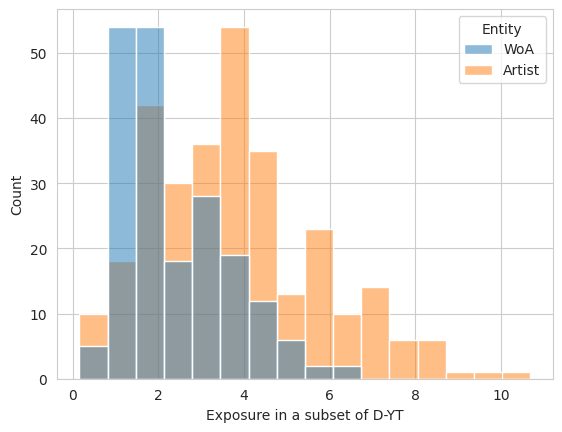

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.histplot(_.dropna(subset="exposure_max"), x="exposure_max", hue="Entity")
plt.xlabel("Exposure in a subset of D-YT")
plt.savefig("../figures/hist_exposure_dataset.pdf")
plt.show()


In [8]:
data_exposure = _.pivot_table(index=['id'],
                              columns='Entity',
                              values=['name', 'sitelinks_max', 'exposure_max'],
                              aggfunc='first').reset_index()
data_exposure.columns = ["id", "exposure_Artist", "exposure_WoA", "name_Artist", "name_WoA", "sitelinks_Artist", "sitelinks_WoA"]
data_exposure


,id,exposure_Artist,exposure_WoA,name_Artist,name_WoA,sitelinks_Artist,sitelinks_WoA
0,1009_1MuNPBL0hMg,1.008419,NaN,vsop,NaN,1.0,NaN
1,1026_Ng4uw6k2RVM,4.324027,1.008419,john kay,i'm movin' on,21.0,1.0
2,1026_idphZ2fY_a0,5.012986,NaN,duane eddy,NaN,29.0,NaN
3,102_O3mnspFrGj8,NaN,2.965611,NaN,you'll never walk alone,NaN,9.0
4,102_nbkPuH9rjKs,4.852235,2.965611,trisha yearwood,you'll never walk alone,27.0,9.0
...,...,...,...,...,...,...,...
389,9840_1FEB2_ywkjU,2.301332,NaN,margie joseph,NaN,5.0,NaN
390,986_6XuJ0E1Qu_c,6.981762,1.008419,django reinhardt,fine and dandy,64.0,1.0
391,9912_nuJnW0ow4bY,3.822592,NaN,little milton,NaN,16.0,NaN
392,9960_wK63eUyk-iM,8.632872,NaN,john travolta,NaN,113.0,NaN


# Results
##### Join Factual Memorization & Wikidata Exposure

In [9]:
data_joint = pd.merge(data_memorization, data_exposure, on="id", how="left").set_index(["subset", "index"])


In [10]:
output_path = "../output/reddit+shsyt/"

def get_IOB_preds(output_path) -> pd.DataFrame:
    """Get multiindex dataframe with predicted IOB lists.
    Args:
        output_path (_type_): _description_
    Returns:
        pd.DataFrame: _description_
    """
    data = pd.DataFrame()

    for model in os.listdir(output_path):
        for f in os.listdir(os.path.join(output_path, model)):
            _ = f.split(".")[0].split("_")
            dataset, k = _[0], int(_[1].replace("shot", ""))
            sampling = _[2] if len(_) > 2 else ""

            preds = read_jsonlines(os.path.join(output_path, model, f))
            _, pred_iobs = get_iobs_from_data(preds)
            _data = pd.DataFrame(pd.Series(pred_iobs), columns=["IOB_pred"]).reset_index()
            _data["subset"] = int(dataset.replace("dataset", ""))
            _data = _data.set_index(["subset", "index"])
            _data.columns =  pd.MultiIndex.from_product([[model], [k], [sampling]])

            _new_cols = _data.columns.difference(data.columns)
    
            if not _new_cols.empty:
                data = pd.concat([data, _data[_new_cols]], axis=1, join='outer')
            else:
                data = data.combine_first(_data)
    
    return data

             
preds = get_IOB_preds(output_path)


# Results!

In [57]:
import sys
sys.path.append("..")
from src.Eval import compute_results
from contextlib import redirect_stdout
import re


def get_model_pred_col(pred_df: pd.DataFrame, model: str) -> str:
    level_values = pred_df.columns.get_level_values(level=0)
    if model.lower() in level_values:
        return model.lower()
    elif model.replace("-", ":").lower() in level_values:
        return model.replace("-", ":").lower()
    return None

def suppress_output(func, *args, **kwargs):
    with open(os.devnull, 'w') as fnull:
        with redirect_stdout(fnull):
            return func(*args, **kwargs)      

def get_results_per_factual_memorization_cls(k, sampling):
    
    #correctness_col = capitalize_first_letter_of_each_sequence(model).replace(":", "-") + "_Correctness"
    correctness_cols = [c for c in data_joint.columns if "_Correctness" in c]
    results = {}   
    for correctness_col in correctness_cols:
        model = correctness_col.split("_")[0]

        col = (get_model_pred_col(preds, model), k, sampling)

        results[model] = {}
        for group in data_joint[correctness_col].dropna().unique():
            try:
                _data = data_joint.loc[data_joint[correctness_col] == group].join(
                    preds.loc[:,col].rename("IOB_pred"), how="inner").dropna(subset=["IOB", "IOB_pred"])
                iob_true = _data.IOB.values
                iob_pred = _data.IOB_pred.values
                results[model][group] = {}

                kwargs = {"true_labels": iob_true, "true_predictions": iob_pred}
                values = suppress_output(compute_results, **kwargs)
                metrics = ["overall_strict_f1_macro", "overall_strict_recall_macro", "Artist_strict_recall", "WoA_strict_recall"]
                for metric in metrics:
                    results [model][group][metric] = values[metric]
            except:
                print(f"Skipping for {col}")

    data = pd.json_normalize(results, sep='_')
    data.columns = pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in data.columns])
    return data.stack(level=1)

model = "llama3.1-70b"
k = 35
sampling = "tfidf"
get_results_per_factual_memorization_cls(k, sampling)


2024-09-12 09:36:32 root INFO: Imported 313 predictions for 313 true examples


2024-09-12 09:36:32 root INFO: Imported 407 predictions for 407 true examples
2024-09-12 09:36:32 root INFO: Imported 63 predictions for 63 true examples
2024-09-12 09:36:32 root INFO: Imported 385 predictions for 385 true examples
2024-09-12 09:36:33 root INFO: Imported 344 predictions for 344 true examples
2024-09-12 09:36:33 root INFO: Imported 54 predictions for 54 true examples
2024-09-12 09:36:33 root INFO: Imported 404 predictions for 404 true examples


Skipping for (None, 35, 'tfidf')
Skipping for (None, 35, 'tfidf')
Skipping for (None, 35, 'tfidf')


2024-09-12 09:36:33 root INFO: Imported 330 predictions for 330 true examples
2024-09-12 09:36:33 root INFO: Imported 49 predictions for 49 true examples
/tmp/ipykernel_1969198/1601775780.py:50: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return data.stack(level=1)


FireFunction-v2                               Llama3.1-70B  \
                  overall              Artist       WoA      overall   
                   strict              strict    strict       strict   
                       f1    recall    recall    recall           f1   
                    macro     macro       NaN       NaN        macro   
0 Correct        0.795329  0.752167  0.787162  0.717172     0.795985   
  None           0.713102  0.664182  0.794118  0.534247     0.703704   
  Partial        0.784725  0.734504  0.801508  0.667500     0.779870   

                                        Mixtral-8x22B                      \
                       Artist       WoA       overall              Artist   
                       strict    strict        strict              strict   
             recall    recall    recall            f1    recall    recall   
              macro       NaN       NaN         macro     macro       NaN   
0 Correct  0.788065  0.762943  0.813187      0.808725  0.786517  0.796438   
  None     0.640476  0.714286  0.566667      0.806122  0.739168  0.830189   
  Partial  0.748555  0.786127  0.710983      0.793332  0.764780  0.835443   

                     
                WoA  
             strict  
             recall  
                NaN  
0 Correct  0.776596  
  None     0.648148  
  Partial  0.694118

In [118]:
def get_results_exposure(k, sampling, exposure_threshold):

    results = {}   

    for model in preds.columns.get_level_values(level=0).unique():
        col = (model, k, sampling)
        if not results.get(model):
            results[model] = {}

        for group in ["seen", "unseen"]:
            for cls in ["Artist", "WoA"]:
                if group == "seen":
                    mask = data_joint[f"exposure_{cls}"] >= exposure_threshold
                else:
                    mask = data_joint[f"exposure_{cls}"].fillna(0) < exposure_threshold

                _data = data_joint.loc[mask].join(
                    preds.loc[:,col].rename("IOB_pred"), how="inner").dropna(subset=["IOB", "IOB_pred", f"exposure_{cls}"])
                iob_true = _data.IOB.values
                iob_pred = _data.IOB_pred.values

                if not results[model].get(cls):
                    results[model][cls] = {}
                if not results[model][cls].get(group):
                    results[model][cls][group] = {}

                kwargs = {"true_labels": iob_true, "true_predictions": iob_pred}
                values = suppress_output(compute_results, **kwargs)
                metrics = ["Artist_strict_recall", "WoA_strict_recall"]
                for metric in metrics:
                    if "overall_" in metric or cls + '_' in metric:
                        results[model][cls][group][metric.split("_")[-1]] = values[metric]

    data = pd.json_normalize(results, sep='_')
    data.columns = pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in data.columns])
    return data.stack(level=2)

get_results_exposure(k, sampling, 1.5)


2024-09-12 10:22:59 root INFO: Imported 296 predictions for 296 true examples
2024-09-12 10:22:59 root INFO: Imported 150 predictions for 150 true examples
2024-09-12 10:32:20 root INFO: Imported 67 predictions for 67 true examples
2024-09-12 10:32:20 root INFO: Imported 104 predictions for 104 true examples
2024-09-12 10:32:20 root INFO: Imported 296 predictions for 296 true examples
2024-09-12 10:32:20 root INFO: Imported 150 predictions for 150 true examples
2024-09-12 10:32:21 root INFO: Imported 67 predictions for 67 true examples
2024-09-12 10:32:21 root INFO: Imported 104 predictions for 104 true examples
2024-09-12 10:32:21 root INFO: Imported 296 predictions for 296 true examples
2024-09-12 10:32:21 root INFO: Imported 150 predictions for 150 true examples
2024-09-12 10:32:21 root INFO: Imported 67 predictions for 67 true examples
2024-09-12 10:32:21 root INFO: Imported 104 predictions for 104 true examples
2024-09-12 10:32:21 root INFO: Imported 296 predictions for 296 true e

firefunction-v2           gpt-4o-mini           llama3.1:70b  \
                  Artist       WoA      Artist       WoA       Artist   
                  recall    recall      recall    recall       recall   
0 seen          0.822464  0.724138    0.862319  0.841379     0.829710   
  unseen        0.826923  0.735294    0.884615  0.862745     0.846154   

                   mixtral:8x22b            
               WoA        Artist       WoA  
            recall        recall    recall  
0 seen    0.772414      0.847826  0.806897  
  unseen  0.803922      0.903846  0.803922